<a href="https://colab.research.google.com/github/ramana16/EVA4/blob/master/EVA4S10%5CS10-T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:

%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S10/')

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from config import ModelConfig
from models.resnet import ResNet18
from train import train
from results import plot_misclassified_images, plot_graph
from utilities import *
from data_engine import DataEngine
from gradcam.visualize import VisualizeCam
from lr_finder import LRFinder
#from test import test

# View model config
args = ModelConfig()
args.print_config()

print()
# Set seed
init_seed(args)

data = DataEngine(args)

Mounted at /content/gdrive/
Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 128,
  'dropout': 0.15,
  'epochs': 50,
  'l1_decay': 3e-06,
  'l2_decay': 0.001,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}

CUDA Available
Files already downloaded and verified
Files already downloaded and verified


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



plane   dog  deer  deer


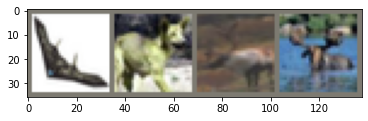

In [20]:
# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))





In [21]:
device = which_device()
net = ResNet18(args.dropout)
model = net.to(device)
show_model_summary(model, (3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
def test(model, device, test_loader, criterion, classes, test_losses, test_accs,
         misclassified_imgs, correct_imgs, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss +=criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 25:
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind]
                })
              
              correct_inds = (is_correct==1).nonzero()[:,0]
              for ind in correct_inds:
                if len(correct_imgs) == 25:
                  break
                correct_imgs.append({
                    "target": target[ind].cpu().numpy(),
                    "pred": pred[ind][0].cpu().numpy(),
                    "img": data[ind]
                })
            correct += is_correct.sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    test_acc = 100. * correct / len(test_loader.dataset)
    test_accs.append(test_acc)

    if test_acc >= 90.0:
        classwise_acc(model, device, test_loader, classes)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))

def classwise_acc(model, device, test_loader, classes):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # print class-wise test accuracies
    print()
    for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))
    print()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


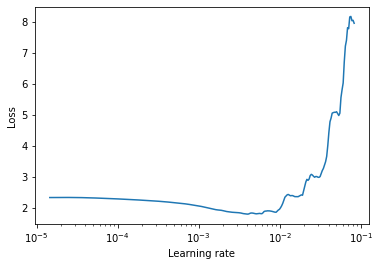

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(data.train_loader, val_loader=data.test_loader, start_lr=1e-5, end_lr=2,
                     num_iter=len(data.train_loader), step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [11]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))
args.lr = best_lr

Best Loss: 1.7908388689987496
Best Learning Rate: 0.004009251706037733


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,
                              verbose=True, min_lr=1e-5)

def run(l1_decay=0.0, l2_decay=0.0):
  test_losses = []
  test_accs = []
  train_losses = []
  train_accs = []
  misclassified_imgs = []
  correct_imgs = []
  for epoch in range(args.epochs):
      print("EPOCH:", epoch+1)
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs)
      test(model, device, data.test_loader, criterion, data.classes, test_losses, test_accs,
           misclassified_imgs, correct_imgs, epoch==args.epochs-1)
      scheduler.step(test_losses[-1])
  return train_losses, train_accs, test_losses, test_accs, misclassified_imgs, correct_imgs

# train and test the model
train_losses, train_accs, test_losses, test_accs, misclassified_imgs, correct_imgs = run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


L2_loss=459.2438049316406 L1_loss=109129.484375 Loss=2.0135955810546875 Batch_id=390 Accuracy=50.30: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0087, Accuracy: 6055/10000 (60.55%)

EPOCH: 2


L2_loss=459.47393798828125 L1_loss=108818.953125 Loss=1.488409399986267 Batch_id=390 Accuracy=68.66: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0058, Accuracy: 7364/10000 (73.64%)

EPOCH: 3


L2_loss=459.5300598144531 L1_loss=108499.640625 Loss=1.4307734966278076 Batch_id=390 Accuracy=76.07: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0053, Accuracy: 7647/10000 (76.47%)

EPOCH: 4


L2_loss=459.53118896484375 L1_loss=108176.6328125 Loss=1.3478693962097168 Batch_id=390 Accuracy=80.48: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0052, Accuracy: 7754/10000 (77.54%)

EPOCH: 5


L2_loss=459.48321533203125 L1_loss=107868.4296875 Loss=1.1907273530960083 Batch_id=390 Accuracy=82.64: 100%|██████████| 391/391 [03:16<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0047, Accuracy: 7978/10000 (79.78%)

EPOCH: 6


L2_loss=459.40771484375 L1_loss=107563.5703125 Loss=1.2622308731079102 Batch_id=390 Accuracy=85.11: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0048, Accuracy: 8036/10000 (80.36%)

EPOCH: 7


L2_loss=459.33917236328125 L1_loss=107274.4375 Loss=1.1841682195663452 Batch_id=390 Accuracy=86.93: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0039, Accuracy: 8383/10000 (83.83%)

EPOCH: 8


L2_loss=459.240234375 L1_loss=106995.25 Loss=1.1250724792480469 Batch_id=390 Accuracy=88.30: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0042, Accuracy: 8234/10000 (82.34%)

EPOCH: 9


L2_loss=459.1315002441406 L1_loss=106726.03125 Loss=1.160491943359375 Batch_id=390 Accuracy=89.54: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0047, Accuracy: 8193/10000 (81.93%)

EPOCH: 10


L2_loss=459.0289306640625 L1_loss=106471.6875 Loss=1.127500295639038 Batch_id=390 Accuracy=90.22: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0039, Accuracy: 8406/10000 (84.06%)

EPOCH: 11


L2_loss=458.8606872558594 L1_loss=106196.75 Loss=0.9120631217956543 Batch_id=390 Accuracy=91.37: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0039, Accuracy: 8424/10000 (84.24%)

EPOCH: 12


L2_loss=458.6658020019531 L1_loss=105929.6171875 Loss=1.036299228668213 Batch_id=390 Accuracy=92.16: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0038, Accuracy: 8536/10000 (85.36%)

EPOCH: 13


L2_loss=458.4554748535156 L1_loss=105651.6015625 Loss=1.2132186889648438 Batch_id=390 Accuracy=93.05: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0037, Accuracy: 8460/10000 (84.60%)

EPOCH: 14


L2_loss=458.24114990234375 L1_loss=105391.7578125 Loss=0.9869236350059509 Batch_id=390 Accuracy=93.35: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0039, Accuracy: 8475/10000 (84.75%)

EPOCH: 15


L2_loss=457.98077392578125 L1_loss=105110.265625 Loss=0.9882128238677979 Batch_id=390 Accuracy=94.13: 100%|██████████| 391/391 [03:16<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0038, Accuracy: 8568/10000 (85.68%)

EPOCH: 16


L2_loss=457.71875 L1_loss=104835.40625 Loss=1.0125641822814941 Batch_id=390 Accuracy=94.46: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0038, Accuracy: 8599/10000 (85.99%)

EPOCH: 17


L2_loss=457.4086608886719 L1_loss=104554.453125 Loss=0.9252351522445679 Batch_id=390 Accuracy=94.84: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0047, Accuracy: 8327/10000 (83.27%)

Epoch    17: reducing learning rate of group 0 to 4.0093e-04.
EPOCH: 18


L2_loss=457.2895202636719 L1_loss=104488.7109375 Loss=0.9319078326225281 Batch_id=390 Accuracy=97.14: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8903/10000 (89.03%)

EPOCH: 19


L2_loss=457.17413330078125 L1_loss=104423.078125 Loss=0.8761682510375977 Batch_id=390 Accuracy=97.87: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8913/10000 (89.13%)

EPOCH: 20


L2_loss=457.0625305175781 L1_loss=104357.4296875 Loss=0.7906218767166138 Batch_id=390 Accuracy=98.21: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0028, Accuracy: 8936/10000 (89.36%)

EPOCH: 21


L2_loss=456.9552001953125 L1_loss=104292.03125 Loss=0.8317115306854248 Batch_id=390 Accuracy=98.34: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8918/10000 (89.18%)

EPOCH: 22


L2_loss=456.85089111328125 L1_loss=104226.703125 Loss=0.7968590259552002 Batch_id=390 Accuracy=98.41: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8924/10000 (89.24%)

EPOCH: 23


L2_loss=456.74981689453125 L1_loss=104161.6484375 Loss=0.850021481513977 Batch_id=390 Accuracy=98.64: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0028, Accuracy: 8919/10000 (89.19%)

EPOCH: 24


L2_loss=456.6473388671875 L1_loss=104096.546875 Loss=0.8273802399635315 Batch_id=390 Accuracy=98.58: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8915/10000 (89.15%)

Epoch    24: reducing learning rate of group 0 to 4.0093e-05.
EPOCH: 25


L2_loss=456.6346130371094 L1_loss=104089.65625 Loss=0.7935099601745605 Batch_id=390 Accuracy=98.77: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0028, Accuracy: 8924/10000 (89.24%)

EPOCH: 26


L2_loss=456.6232604980469 L1_loss=104082.9609375 Loss=0.8196456432342529 Batch_id=390 Accuracy=98.82: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0028, Accuracy: 8935/10000 (89.35%)

EPOCH: 27


L2_loss=456.612548828125 L1_loss=104076.28125 Loss=0.78086256980896 Batch_id=390 Accuracy=98.82: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0028, Accuracy: 8923/10000 (89.23%)

EPOCH: 28


L2_loss=456.6019592285156 L1_loss=104069.59375 Loss=0.8111687898635864 Batch_id=390 Accuracy=98.74: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8936/10000 (89.36%)

Epoch    28: reducing learning rate of group 0 to 1.0000e-05.
EPOCH: 29


L2_loss=456.59918212890625 L1_loss=104067.9296875 Loss=0.8150978088378906 Batch_id=390 Accuracy=98.79: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8919/10000 (89.19%)

EPOCH: 30


L2_loss=456.59661865234375 L1_loss=104066.2578125 Loss=0.7935471534729004 Batch_id=390 Accuracy=98.72: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8931/10000 (89.31%)

EPOCH: 31


L2_loss=456.5941467285156 L1_loss=104064.59375 Loss=0.7905879020690918 Batch_id=390 Accuracy=98.82: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8919/10000 (89.19%)

EPOCH: 32


L2_loss=456.59173583984375 L1_loss=104062.9140625 Loss=0.8043824434280396 Batch_id=390 Accuracy=98.88: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8942/10000 (89.42%)

EPOCH: 33


L2_loss=456.58929443359375 L1_loss=104061.25 Loss=0.8040816783905029 Batch_id=390 Accuracy=98.83: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0028, Accuracy: 8924/10000 (89.24%)

EPOCH: 34


L2_loss=456.5867614746094 L1_loss=104059.578125 Loss=0.786560595035553 Batch_id=390 Accuracy=98.78: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8934/10000 (89.34%)

EPOCH: 35


L2_loss=456.5843200683594 L1_loss=104057.9140625 Loss=0.8077016472816467 Batch_id=390 Accuracy=98.83: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0028, Accuracy: 8924/10000 (89.24%)

EPOCH: 36


L2_loss=456.58184814453125 L1_loss=104056.25 Loss=0.813783586025238 Batch_id=390 Accuracy=98.76: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8937/10000 (89.37%)

EPOCH: 37


L2_loss=456.57940673828125 L1_loss=104054.5703125 Loss=0.7874984741210938 Batch_id=390 Accuracy=98.76: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8926/10000 (89.26%)

EPOCH: 38


L2_loss=456.5768737792969 L1_loss=104052.9140625 Loss=0.8194901943206787 Batch_id=390 Accuracy=98.85: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8938/10000 (89.38%)

EPOCH: 39


L2_loss=456.57440185546875 L1_loss=104051.25 Loss=0.7995502948760986 Batch_id=390 Accuracy=98.89: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0028, Accuracy: 8926/10000 (89.26%)

EPOCH: 40


L2_loss=456.5719299316406 L1_loss=104049.578125 Loss=0.8288350105285645 Batch_id=390 Accuracy=98.81: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0028, Accuracy: 8936/10000 (89.36%)

EPOCH: 41


L2_loss=456.5694885253906 L1_loss=104047.9140625 Loss=0.7867063879966736 Batch_id=390 Accuracy=98.84: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0028, Accuracy: 8925/10000 (89.25%)

EPOCH: 42


L2_loss=456.5671081542969 L1_loss=104046.2578125 Loss=0.787800669670105 Batch_id=390 Accuracy=98.83: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8926/10000 (89.26%)

EPOCH: 43


L2_loss=456.5646057128906 L1_loss=104044.5703125 Loss=0.8223069906234741 Batch_id=390 Accuracy=98.86: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8938/10000 (89.38%)

EPOCH: 44


L2_loss=456.5621337890625 L1_loss=104042.921875 Loss=0.790282130241394 Batch_id=390 Accuracy=98.87: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0028, Accuracy: 8928/10000 (89.28%)

EPOCH: 45


L2_loss=456.5596618652344 L1_loss=104041.2421875 Loss=0.8317104578018188 Batch_id=390 Accuracy=98.81: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0028, Accuracy: 8930/10000 (89.30%)

EPOCH: 46


L2_loss=456.5571594238281 L1_loss=104039.578125 Loss=0.8228074312210083 Batch_id=390 Accuracy=98.74: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0028, Accuracy: 8926/10000 (89.26%)

EPOCH: 47


L2_loss=456.55474853515625 L1_loss=104037.90625 Loss=0.8185076713562012 Batch_id=390 Accuracy=98.89: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8920/10000 (89.20%)

EPOCH: 48


L2_loss=456.55224609375 L1_loss=104036.25 Loss=0.8230801820755005 Batch_id=390 Accuracy=98.82: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8934/10000 (89.34%)

EPOCH: 49


L2_loss=456.5498962402344 L1_loss=104034.5859375 Loss=0.8008704781532288 Batch_id=390 Accuracy=98.91: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8919/10000 (89.19%)

EPOCH: 50


L2_loss=456.54736328125 L1_loss=104032.90625 Loss=0.8864026069641113 Batch_id=390 Accuracy=98.83: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]


Test set: Average loss: 0.0028, Accuracy: 8928/10000 (89.28%)



Let us show some of the training images, for fun.



TypeError: ignored

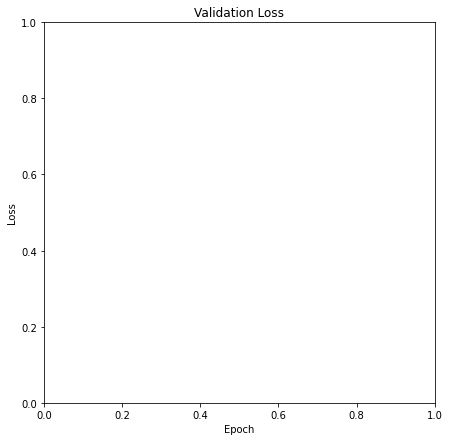

In [13]:
plt_data = {
    "val": test_losses
}
plot_graph(plt_data, "Loss")

TypeError: ignored

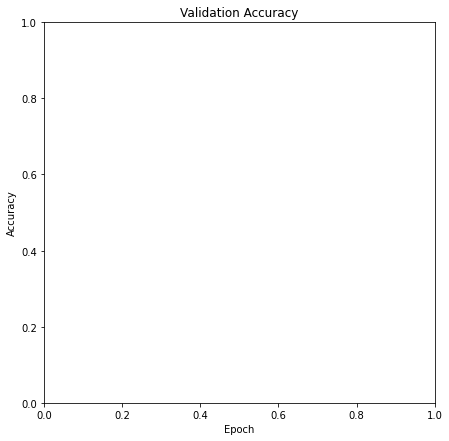

In [14]:

plt_data = {
    "train": train_accs,
    "val": test_accs
}
plot_graph(plt_data, "Accuracy")

TypeError: ignored

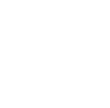

In [15]:
plot_misclassified_images(misclassified_imgs, data.classes, "misclassified_imgs.png")

In [0]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

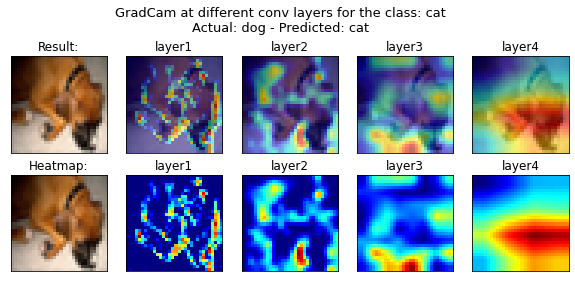

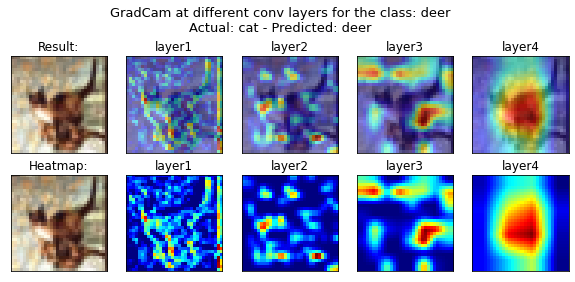

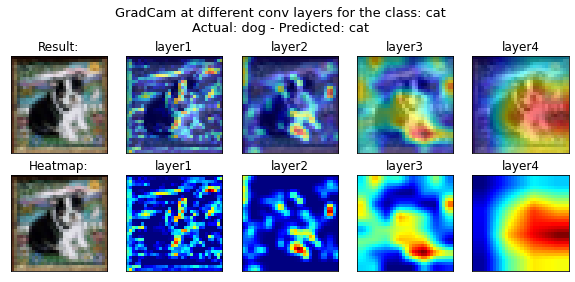

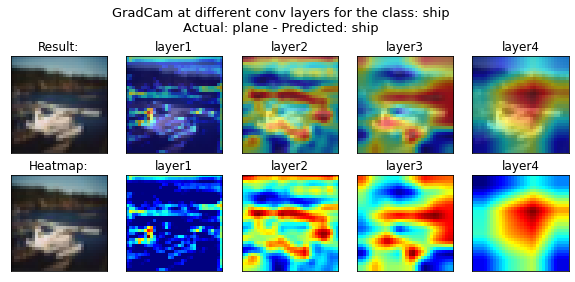

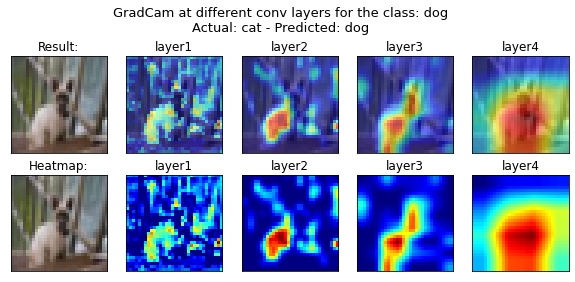

In [17]:
num_img = 5
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect")

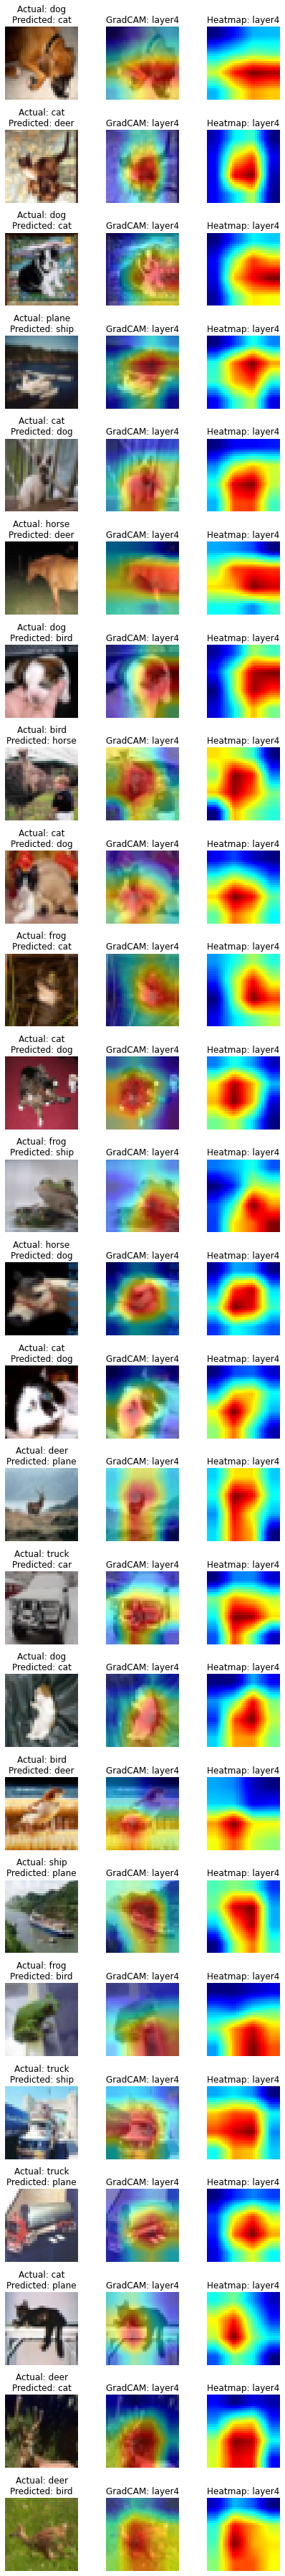

In [18]:
num_img = 25
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect", per_image=False)